### Google.colab
Only execute this cell when use on google colab platform (colab).

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://github.com/Nak007/recommendation">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In [ ]:
# Mount with google drive.
from google.colab import drive
drive.mount('/content/dirve')

In [ ]:
import sys
!git clone 'http://github.com/Nak007/recommendation.git'
sys.path.append('/content/recommendation')

## Example

In [8]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
pd.options.display.float_format = '{:,.4f}'.format

This dataset describes 5-star rating and free-text tagging activity from [MovieLens](http://movielens.org), a movie recommendation service. It contains 100836 ratings and 3683 tag applications across 9742 movies. These data were created by 610 users between March 29, 1996 and September 24, 2018. This dataset was generated on September 26, 2018.

In [9]:
ratings = pd.read_csv("ratings.csv")

`timestamp` represent seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970. Convert `timestamp` to date-time format.

In [10]:
ratings["timedelta"] = ratings["timestamp"].astype(int)
ratings["timestamp"] = [np.datetime64("1970-01-01") + np.timedelta64(t,"s") 
                        for t in ratings["timestamp"].values]

In [11]:
ratings.head()

,userId,movieId,rating,timestamp,timedelta
0,1,1,4.0000,2000-07-30 18:45:03,964982703
1,1,3,4.0000,2000-07-30 18:20:47,964981247
2,1,6,4.0000,2000-07-30 18:37:04,964982224
3,1,47,5.0000,2000-07-30 19:03:35,964983815
4,1,50,5.0000,2000-07-30 18:48:51,964982931


Create `rating_scr`, and `rating_dt`, of shape (`n_userIds`,`n_movieIds`).

In [12]:
rating_scr = ratings.pivot_table(values="rating", index="userId", columns="movieId").values
date = np.datetime64("1970-01-01")
rating_dt = ratings.pivot_table(values="timedelta", index="userId", columns="movieId").values
rating_dt = date + np.where(np.isnan(rating_dt), 0, rating_dt).astype("timedelta64[s]")
rating_dt = np.where(rating_dt<=date, np.datetime64("NaT"), rating_dt)

Create dateset with respect to $n$ month.

In [13]:
months = np.arange("2018-01-01", "2018-10-01", 1, dtype="datetime64[M]")
datasets = [np.where(rating_dt<=mth, rating_scr, np.nan) for mth in months]
print("There are {:,.0f} datasets being created.".format(len(datasets)))

There are 9 datasets being created.


We are reducing data sparsity problem (to certian extent) by selecting $n^{th}$ most-watched movies.

In [14]:
data = np.where(np.isnan(datasets[0]), np.nan, 1)
most_watched = np.nansum(data, axis=0)/data.shape[0]
sorted_most_watched = np.sort(most_watched)[::-1]

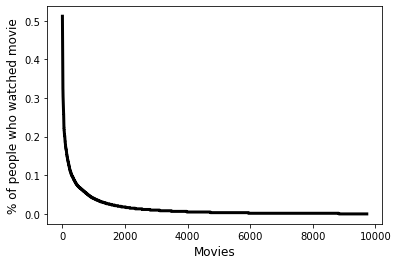

In [15]:
n_movies = datasets[0].shape[1]
plt.plot(np.arange(n_movies)+1, sorted_most_watched, lw=3, c="k")
plt.ylabel("% of people who watched movie", fontsize=12)
plt.xlabel("Movies", fontsize=12)
plt.show()

We select the first $K$ movies.

In [16]:
threshold = sorted_most_watched[:50].min()
selected_movies = sorted_most_watched>=threshold
print("{:,.0f} movies are selected (cut-off : {:.2%}).".format(sum(selected_movies), threshold))

51 movies are selected (cut-off : 22.30%).


Sparsity after selecting $n$ most-watched movies.

In [17]:
X = datasets[0][:, selected_movies]

In [18]:
sparsity = np.isnan(X).sum()/X.size
print("Sparsity : {:.2%}".format(sparsity))

Sparsity : 91.76%


Split ratings into random train and test subsets i.e. **X_train**, and **X_test**.

In [40]:
test_size = 0.2
X_train, X_test = rating_train_test(X, test_size, random_state=0)

**Regularized Stochastic Gradient Descent**
    
`RSGD` implements "Collaborative Filtering" (CF) by using "Matrix Factorization" (MF) that minimizes cost function using gradient descent (biases included) to derive a matrix $P$ containing the latent factors of the user and a matrix $Q$ containing those of the items. The prediction of a rating of an item $Q_{j}$ by $P_{i}$ is as follows: 

$\hat{r_{i,j}} \approx \mu + b_{i} + b_{j} + P_{i}Q_{j}^{T} $. 

where $b_{i}$ is the user $i$ bias, $b_{j}$ is the item $j$ bias, and $\mu$ is the global average of ratings of all the user- item ratings.

The cost function is as follows:

$L = \sum_{i=1}^{N}\sum_{j\in J(i)}( r_{i,j} - \hat{r_{i,j}})^2 + \lambda(\vert\vert P \vert\vert^{2} + \vert\vert Q \vert\vert^{2} + b_{i}^{2} + b_{j}^{2})$

where $N$ is the number of users, $J(i)$ is the number of items of user $i$, $\lambda$ is the regularization parameter, and $\vert\vert . \vert\vert$ is the Frobenius norm.

In [41]:
estimator = RSGD(biased=False, random_state=0, 
                 patience=10 , verbose=True, 
                 alpha=0.001 , random="uniform", 
                 lr_kwds={"method":None})

rating = estimator.fit_predict(X_train, n_factors=4, X_val=X_test)

Stopping Criteria
Converge  : 0.054 (Max=0.0001)
------------------------------
Patience  : 10 (Max=10)
------------------------------
Iteration : 151 (Max=5,000)


Observe the learning curve of two datesets i.e Train and Test.

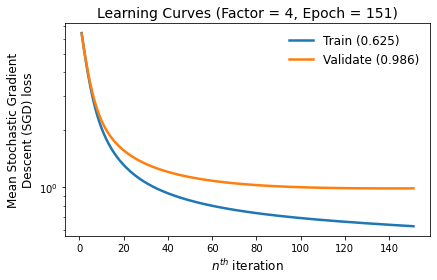

In [42]:
ax = estimator.plotting(monitor="loss")
ax.set_yscale('log')

In [44]:
np.round(np.clip(rating, 1, 5), 2)

array([[4.31, 3.79, 3.52, ..., 3.08, 1.64, 2.5 ],
       [3.71, 3.11, 2.92, ..., 2.66, 1.25, 2.  ],
       [2.42, 2.01, 2.42, ..., 1.99, 1.19, 1.35],
       ...,
       [3.42, 3.04, 2.5 , ..., 2.35, 1.25, 2.16],
       [4.55, 4.04, 3.98, ..., 3.31, 1.81, 2.52],
       [4.48, 3.79, 3.71, ..., 3.26, 1.62, 2.42]])

Hyperparameter tuning

In [45]:
parameters = [("w/o bias (uniform)", 
               dict(biased=False, random_state=0, patience=10, 
                    verbose=False, alpha=0.001, random="uniform")),
              ("w/  bias (normal)", 
               dict(biased=True, random_state=0, patience=10, 
                    verbose=False, alpha=0.001, random="normal")),
              ("w/  bias (uniform)", 
               dict(biased=True, random_state=0, patience=10, 
                    verbose=False, alpha=0.001, random="uniform")),
              ("w/  bias (normal, step)", 
               dict(biased=True, random_state=0, patience=10, 
                    verbose=False, alpha=0.01, random="normal", 
                    lr_kwds={"method":"step"}))]

Out-of-time datesets

In [46]:
X_tests = [a[:, selected_movies] for a in datasets[1:]]
X_base  = datasets[0][:, selected_movies]

Use **`RecommenderScores()`** to calculate evaluation metrics for recommender as follows;
1. Root mean square error (`rmse`)        
2. Mean absolute error (`mae`) 
3. Mean Discounted Cumulative Gain (`dcg`) 
4. Mean Normalized Discounted Cumulative Gain (`ndcg`). 
5. Hit-rate (`hitrate`)
6. Precision (`precision`)
7. Recall (`recall`)

In [47]:
ratings = []
kwargs  = dict(n_factors=3, X_val=X_test)
for name, kwds in parameters:
    print(f"Processing . . . {name}")
    estimator = RSGD(**kwds)
    X_score   = estimator.fit_predict(X_train, **kwargs)
    X_eval    = RecommenderScores(X_base, X_tests, X_score, k=5, kwargs={"k":5})
    ratings  += [(name, X_score, X_eval)]
    
print("Tasks completed succesfully . . .")

Processing . . . w/o bias (uniform)
Processing . . . w/  bias (normal)
Processing . . . w/  bias (uniform)
Processing . . . w/  bias (normal, step)
Tasks completed succesfully . . .


The function `plot_results` is used to plot the evaluation metrics.

In [48]:
def plot_results(ratings, metric="rmse", plot_kwds=None, x=None, ax=None):
    
    title   = "Regularized Stochastic Gradient Descent"
    ylabels = {"rmse"     : "Root mean square error", 
               "mae"      : "Mean absolute error",
               "dcg"      : "Mean Discounted Cumulative Gain",
               "ndcg"     : ("Mean Normalized\nDiscounted "
                             "Cumulative Gain"),
               "hitrate"  : "Hit-rate",
               "precision": "Precision",
               "recall"   : "Recall"}
    
    ax   = plt.subplots()[1] if ax is None else ax
    kwds = {"linewidth" : 1.5, "marker" : "o"}
    kwds.update(({} if plot_kwds is None else plot_kwds))
    
    for name, _, eval_metric in ratings:
        y = getattr(eval_metric, metric)
        x = np.arange(len(y)) if x is None else x
        ax.plot(x, y, **{**kwds,**dict(label=name)})
        
    ax.set_ylabel(ylabels[metric], fontsize=12)
    ax.legend(loc=0, fontsize=12)
    ax.set_title(title, fontsize=14)
    plt.tight_layout()
    return ax

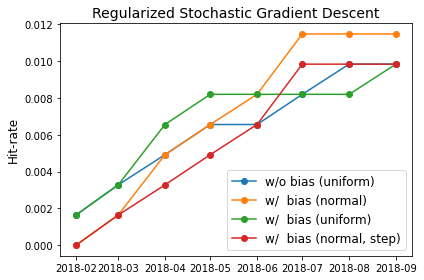

In [49]:
ax = plot_results(ratings, "hitrate", x=months[1:])

Actual **Hit-rate**

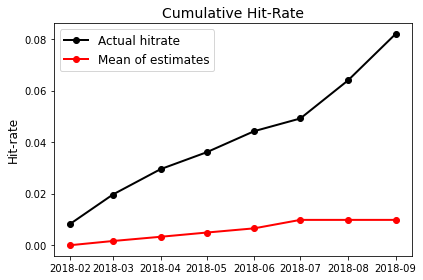

In [87]:
x  = months[1:]
y = ratings[0][2].n_ratings/len(X_train)

Scores = np.zeros(X_train.shape)
for n in ratings: Scores  += n[1]
avg_scores  = Scores/len(ratings)
avg_hitrate = RecommenderScores(X_base, X_tests, avg_scores,
                                k=5, kwargs={"k":5}).hitrate

plt.plot(x, y, marker="o", linewidth=2, 
         c='k', label="Actual hitrate")
plt.plot(x, avg_hitrate, marker="o", 
         linewidth=2, c='r', label="Mean of estimates")
plt.ylabel("Hit-rate", fontsize=12)
plt.title("Cumulative Hit-Rate", fontsize=14)
plt.legend(loc=0, fontsize=12)
plt.tight_layout()
plt.show()

Use **`ItemReccommender()`** to create recommendations for respective users wrt. predicted scores/ratings.

In [88]:
selected_ratings = ratings[1][1]

In [89]:
items = ['item_{}'.format(str(n).zfill(2)) for n in np.arange(X_train.shape[1])+1]
rec_items, rec_scores = ItemReccommender(X_train, selected_ratings, items=items)

Top-5 recommendations for each user.

In [90]:
rec_items[:,:5]

array([['item_47', 'item_32', 'item_16', 'item_29', 'item_17'],
       ['item_44', 'item_47', 'item_01', 'item_17', 'item_06'],
       ['item_47', 'item_32', 'item_01', 'item_06', 'item_44'],
       ...,
       ['item_44', 'item_06', 'item_29', 'item_17', 'item_11'],
       ['item_47', 'item_06', 'item_44', 'item_32', 'item_01'],
       ['item_06', 'item_29', 'item_17', 'item_11', 'item_34']],
      dtype=object)